# Result Analysis

The folder `results` contains the results of the experiments. The results are stored in the form of
JSON files. Depending on the experiment, different files can be genrated.

* `metrics.json`: Content of the `distributed_metrics` attribute at the end of the FL process
* `distribution.json`: Initial distribution of the clients per dataset
* `clusters.json`: Cluster assignments of the clients per round of FL
* `xeval_{i}.json`: Cross-evaluation matrix at the `i`-th round

In [23]:
import json

import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from trustfids.utils.results import load_results

## Analysis of ONE experiment

In [24]:
# --------------------------------------------------------------------------------------
config, metrics, distribution, clusters, xevals = load_results("../outputs/2023-09-29/16-06-36")
metric = "accuracy"
rounds = [r+1 for r in range(len(next(iter(metrics.values()))))]
# --------------------------------------------------------------------------------------

### Metric destribution over all participants

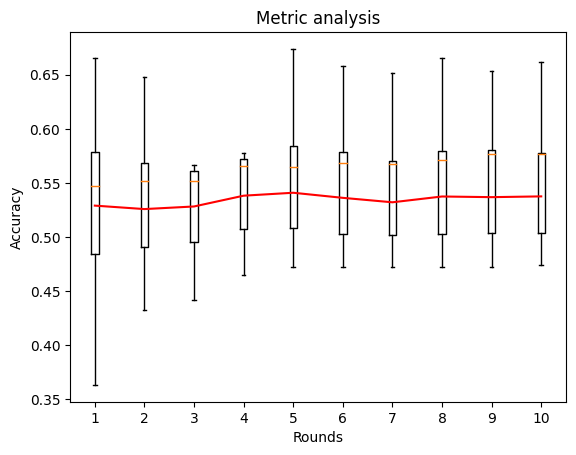

In [25]:
plt.figure()
plt.title("Metric analysis")
plt.xlabel("Rounds")
plt.ylabel(metric.title() if metric != "loss" else "Normalized loss")

means = []

for rnd in range(len(rounds)):
    points = []
    for m_client in metrics.values():
        points.append( m_client[rnd][1][metric])
    
    plt.boxplot(points, positions=[rounds[rnd]], showfliers=False)

    means.append(np.mean(points))

plt.plot(rounds, means, color="red", label="Mean")


### Metric per client

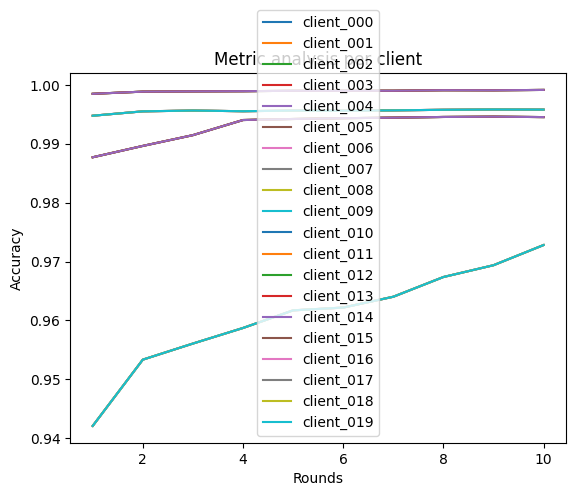

In [35]:
plt.figure()
plt.title("Metric analysis per client")
plt.xlabel("Rounds")
plt.ylabel(metric.title())

clients_res = {}
for rnd in range(len(rounds)):
    for cid, res in metrics.items():
        if cid not in clients_res: clients_res[cid] = []
        clients_res[cid].append(res[rnd][1][metric])

for cid in clients_res.keys():
    plt.plot(rounds, clients_res[cid], label=f"{cid}")

    

plt.legend()

### Metric mean by cluster (original client distribution)

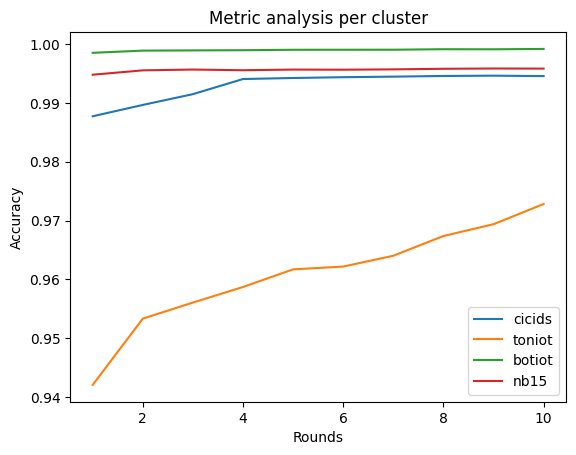

In [36]:
plt.figure()
plt.title("Metric analysis per cluster")
plt.xlabel("Rounds")
plt.ylabel(metric.title())

clust_means = {k: [] for k in distribution}

for rnd in range(len(rounds)):
    for k, d in distribution.items():
        values = []
        for cid, res in metrics.items():
            if cid in d:
                values.append(res[rnd][1][metric])
        clust_means[k].append(np.mean(values))

for k in distribution.keys():
    plt.plot(rounds, clust_means[k], label=f"{k.split('/')[-1].split('.')[0]}")

plt.legend()



## Analysis of MANY experiments

In [37]:
# --------------------------------------------------------------------------------------
results = load_results(
    "../multirun/2023-06-20/00-46-49/archi=foolsgold,scenario_attacker=loud,scenario_distribution=sybils",
    "../multirun/2023-06-20/00-46-49/archi=trustfids,scenario_attacker=loud,scenario_distribution=sybils",
    multirun=True
)
metric = "accuracy"
_, metrics, _, _, _ = results[0]
rounds = [r+1 for r in range(len(next(iter(metrics.values()))))]
# --------------------------------------------------------------------------------------

### Baseline comparison (mean)

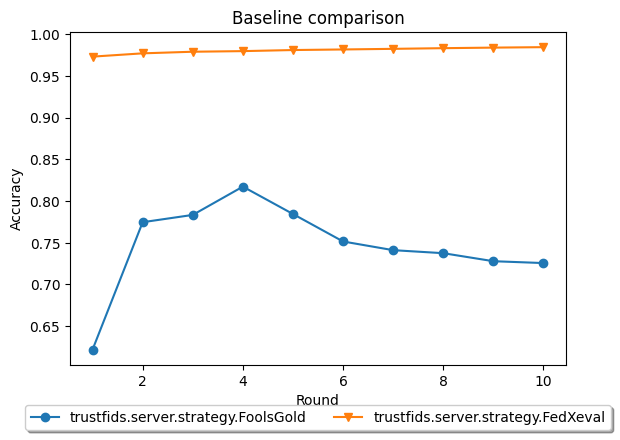

In [38]:
plt.figure()
plt.title("Baseline comparison")
plt.xlabel("Round")
plt.ylabel(metric.title())
ax = plt.subplot(111)

markers = ["o", "v", "s", "P", "X", "D", "p", "h", "H", "d", "*", "x", "^", "<", ">"]


for i, run in enumerate(results):
    config, metrics, distribution, clusters, xevals = run

    means = []

    if metrics is None:
        continue

    for rnd in range(len(rounds)):
        values = []
        for cid, client_metrics in metrics.items():
            if "attacker" not in cid:
                values.append(client_metrics[rnd][1][metric])
        means.append(np.mean(values))

    #clu_met = config.archi.strategy.clustering_metric or config.archi.strategy.evaluation_metric
    #rep_met = config.archi.strategy.reputation_metric or config.archi.strategy.evaluation_metric

    ax.plot(
        rounds,
        means,
        label=f"{config.archi.strategy._target_}",
        #label=f"{clu_met}-{rep_met} ({config.archi.strategy.clustering_kwargs.input_type})",
        marker=markers[i]
    )
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=4)


### Baseline comparison (per cluster)

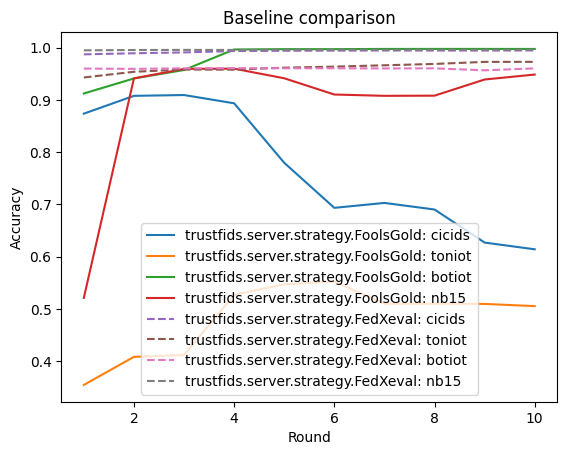

In [39]:
plt.figure()
plt.title("Baseline comparison")
plt.xlabel("Round")
plt.ylabel(metric.title())

styles = ["-", "--", "-.", ":"]

for i, run in enumerate(results):
    config, metrics, distribution, clusters, xevals = run

    # clust_means = {j: [] for j, _ in enumerate(distribution)}

    # for rnd in range(len(rounds)):
    #     for j, k in enumerate(distribution):
    #         values = []
    #         for cid, results in metrics.items():
    #             if cid in k:
    #                 values.append(results[rnd][1][metric])
    #         clust_means[j].append(np.mean(values))

    # for k in distribution.keys():
    #     style = styles[i % len(styles)]
    #     plt.plot(rounds, clust_means[k], label=f"{config.baseline.name}: {cs[1].split('/')[-1].split('.')[0]}", linestyle=style)

    clust_means = {k: [] for k in distribution}

    for rnd in range(len(rounds)):
        for k, d in distribution.items():
            values = []
            for cid, res in metrics.items():
                if cid in d and "attacker" not in cid:
                    values.append(res[rnd][1][metric])
            clust_means[k].append(np.mean(values))

    for k in distribution.keys():
        style = styles[i % len(styles)]
        plt.plot(rounds, clust_means[k], label=f"{config.archi.strategy._target_}: {k.split('/')[-1].split('.')[0]}", linestyle=style)

plt.legend()

#plt.legend()

## Analysis of CENTRALIZED experiments

### Dataset analysis

In [40]:
# --------------------------------------------------------------------------------------
results = json.load(Path("./centralized/metrics_sampled.json").open())
runs = results["runs"]
metric = "f1"
rounds = [r+1 for r in range(len(next(iter(runs.values()))["eval"]))]
# --------------------------------------------------------------------------------------

### Centralized model

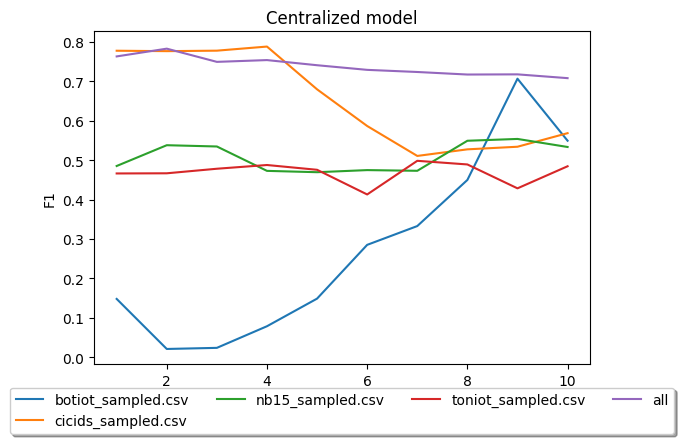

In [41]:
plt.figure()
plt.title("Centralized model")
plt.xlabel("Round")
plt.ylabel(metric.title())
ax = plt.subplot(111)


for dataset, run in runs.items():
    
    stats = run["stats"]
    evals = run["eval"]

    points = [e[1][metric] for e in evals]

    ax.plot(
        rounds,
        points,
        label=f"{dataset}",
    )

box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=4)